In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rc('figure',figsize=(17,13))
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()


import re
import string 

import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud
from tqdm.auto import tqdm

In [2]:
df1=pd.read_csv(r'tweets-2.csv')
df=df1.head(500)
df.head()

user_name                                               text  \
0           Bohmle  #GPT4 for FREE. \nNo its not a clickbait, @Qol...   
1              NaN                                      AI enthusiast   
2     Dan Bruno AI  ChatGPT Thinks These 5 Crypto Coins Will Explo...   
3  Georgiana Comsa  New: @JWVance's post about 5 #startups (includ...   
4     Bitone Great  🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation:...   

               user_location  \
0                  Carkingga   
1  2019-07-03 03:44:41+00:00   
2             Manchester, NH   
3                  Palo Alto   
4                  Hong Kong   

                                    user_description  \
0                                                NaN   
1                                               60.0   
2  The latest in #ChatGPT, #BARD, #Bing, and othe...   
3  Founder of Silicon Valley PR, award-winning PR...   
4  #ChatGPT (AI) powered Free Trading Signal! \nL...   

                user_created user_followers user_friends  \
0                        NaN            NaN          NaN   
1                      349.0            611        False   
2  2021-05-19 01:19:32+00:00          470.0        157.0   
3  2008-12-24 09:32:23+00:00         3864.0       1883.0   
4  2022-11-21 04:42:18+00:00         1517.0        506.0   

             user_favourites         user_verified                       date  \
0                        NaN                   NaN                        NaN   
1  2023-05-17 18:11:12+00:00  ['GPT4', 'ChatGPT4']            Twitter Web App   
2                       5185                 False  2023-05-17 18:11:03+00:00   
3                       2415                 False  2023-05-17 18:10:25+00:00   
4                         64                 False  2023-05-17 18:09:39+00:00   

                           hashtags           source  
0                               NaN              NaN  
1                               NaN              NaN  
2       ['chatgpt', 'AI', 'openAI']          dlvr.it  
3         ['startups', 'startup50']  Twitter Web App  
4  ['Binance', 'Short', 'GHSTUSDT']             rsi1

In [3]:
print('Rows              :',df.shape[0])
print('Columns           :',df.shape[1])
print('\nFeatures        :\n',df.columns.tolist())
print('\nMissing values  :',df.isna().sum().values.sum())
print('\nUnique values   :',df.nunique())

Rows              : 500
Columns           : 12

Features        :
 ['user_name', 'text', 'user_location', 'user_description', 'user_created', 'user_followers', 'user_friends', 'user_favourites', 'user_verified', 'date', 'hashtags', 'source']

Missing values  : 276

Unique values   : user_name           392
text                496
user_location       234
user_description    372
user_created        392
user_followers      326
user_friends        343
user_favourites     344
user_verified         2
date                468
hashtags            213
source               57
dtype: int64


In [4]:
df['user_name'].value_counts()

Bitone Great              20
Dan Bruno AI              14
Gary Zee                   9
Anthony Hadfield Ph.D.     7
Elitsa Krumova             7
                          ..
Bigram Poetry              1
Yarin Cohen                1
Moddable                   1
Magzter                    1
ManTFupTV                  1
Name: user_name, Length: 392, dtype: int64

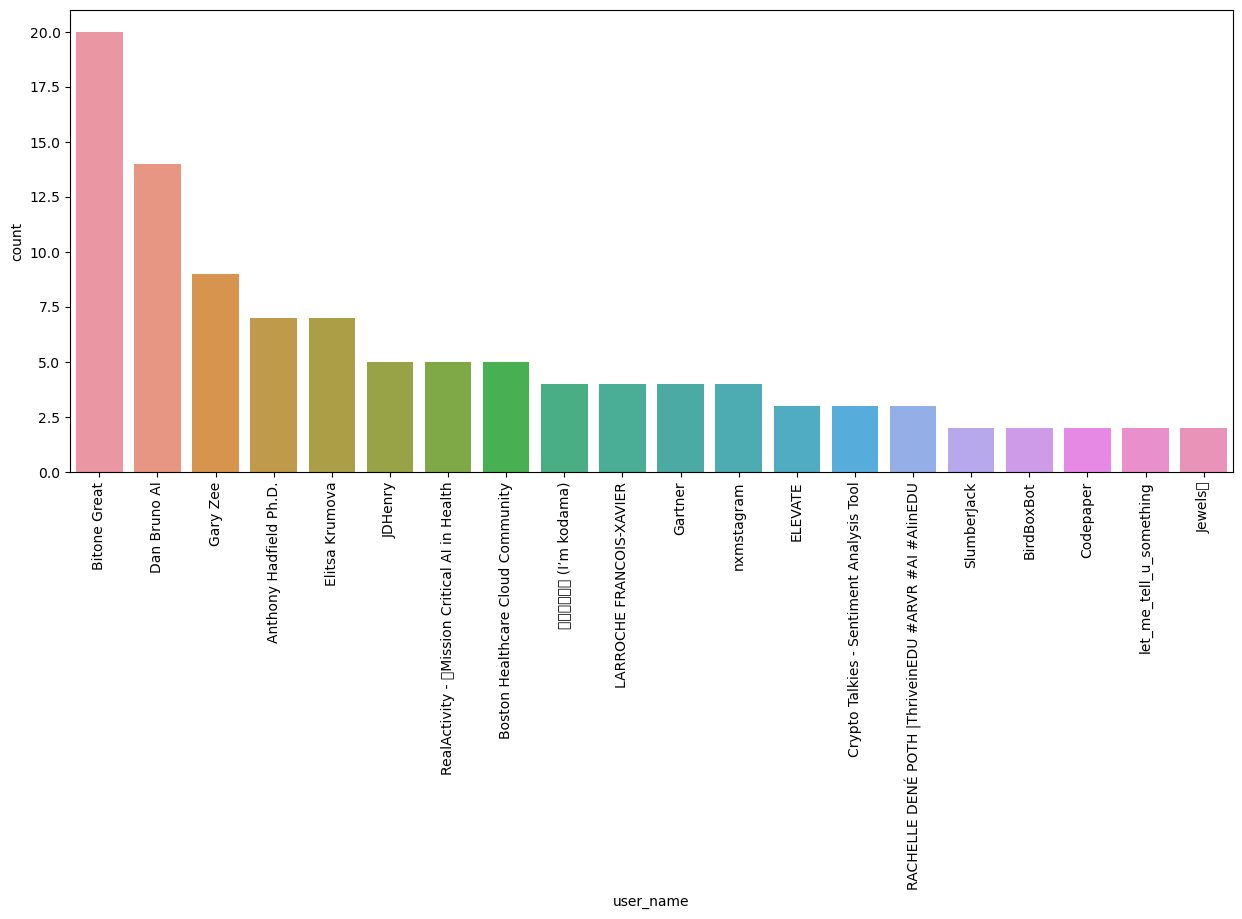

In [5]:
plt.figure(figsize=(15,6))
sns.countplot(data=df, x='user_name', order=df["user_name"].value_counts().index[:20])
plt.xticks(rotation=90)
plt.show()

In [6]:
df['hashtags']=df['hashtags'].fillna('[]')

all_hashtags=[]
for i in range(len(df['hashtags'])):
    a=df['hashtags'][i].strip('][').split(',')
    for i in a:
        all_hashtags.append(i)
all_hashtags=['No hashtags' if x=='' else x for x in all_hashtags]

all_hashtags=pd.Series(np.array(all_hashtags))
print('There are {} instances of tweets in which No hashtags were used'.format(all_hashtags.value_counts()[1]))

common_hashtags=all_hashtags.value_counts().drop(labels='No hashtags')[:30].rename_axis('Common Hashtags').reset_index(name='count')
fig=px.treemap(common_hashtags,path=['Common Hashtags'],values='count',title='Top 30 Common Hashtags')
fig.show()

There are 132 instances of tweets in which No hashtags were used


In [7]:
data_=df['source'].value_counts().reset_index()

trace1=go.Bar(x=['Twitter Web App', 'Twitter for iPhone', 'Twitter for Android','LinkedIn', 'HubSpot', 'IFTTT', 
                 'Hypefury', 'Sprout Social','Revive Social App', 'Buffer'],
              y=data_['source'],marker=dict(color='rgb(250,13,92)',
              line=dict(color='rgb(0,0,0)',width=1.5)),text=data_['source'],textposition='outside')

layout=go.Layout(template='plotly_dark',title='Top 10 Most Source Disrtibution Of Tweets',xaxis=dict(title='Source'),
                 yaxis=dict(title='Count'),height=700)
fig=go.Figure(data=[trace1],layout=layout)
fig.show()

## Pre-Processing & Cleaning

In [8]:

def remove_line_breaks(text):
    text = text.replace('\r', ' ').replace('\n', ' ')
    return text

#remove punctuation
def remove_punctuation(text):
    re_replacements = re.compile("__[A-Z]+__")  # such as __NAME__, __LINK__
    re_punctuation = re.compile("[%s]" % re.escape(string.punctuation))
    '''Escape all the characters in pattern except ASCII letters and numbers'''
    tokens = word_tokenize(text)
    tokens_zero_punctuation = []
    for token in tokens:
        if not re_replacements.match(token):
            token = re_punctuation.sub(" ", token)
        tokens_zero_punctuation.append(token)
    return ' '.join(tokens_zero_punctuation)


def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def lowercase(text):
    text_low = [token.lower() for token in word_tokenize(text)]
    return ' '.join(text_low)

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    text = " ".join([word for word in word_tokens if word not in stop])
    return text

def remove_one_character_words(text):
    '''Remove words from dataset that contain only 1 character'''
    text_high_use = [token for token in word_tokenize(text) if len(token)>1]      
    return ' '.join(text_high_use)   
    
#%%
# Stemming with 'Snowball stemmer" package
def stem(text):
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    text_stemmed = [stemmer.stem(token) for token in word_tokenize(text)]        
    return ' '.join(text_stemmed)

def lemma(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    text_lemma = " ".join([wordnet_lemmatizer.lemmatize(word) for word in word_tokens])       
    return ' '.join(text_lemma)

def sentence_word(text):
    word_tokens = nltk.word_tokenize(text)
    return word_tokens
#break paragraphs to sentence token 
def paragraph_sentence(text):
    sent_token = nltk.sent_tokenize(text)
    return sent_token    

def tokenize(text):
    """Return a list of words in a text."""
    return re.findall(r'\w+', text)

def remove_numbers(text):
    no_nums = re.sub(r'\d+', '', text)
    return ''.join(no_nums)

def clean_text(text):
    _steps = [
    remove_line_breaks,
    remove_one_character_words,
    remove_special_characters,
    lowercase,
    remove_punctuation,
    remove_stopwords,
    stem,
    remove_numbers
]
    for step in _steps:
        text=step(text)
    return text   

In [9]:
df['text']=df['text'].astype(str)
df['text']=[x.replace(':',' ') for x in df['text']]
df['text']

0      #GPT4 for FREE. \nNo its not a clickbait, @Qol...
1                                          AI enthusiast
2      ChatGPT Thinks These 5 Crypto Coins Will Explo...
3      New  @JWVance's post about 5 #startups (includ...
4      🚨Get Out!🚨\n💰#Binance Spot💰\n⬇ Recommendation ...
                             ...                        
495    #ChatGPT set off an endless stream of fear and...
496    ChatGPT is a hot topic; there is no doubt. It ...
497    Exciting news! #chatGPT has launched its Plugi...
498    @Oncrawl Agreed! The #ChatGPT is definitely th...
499    Do you agree whatever is put on the internet d...
Name: text, Length: 500, dtype: object

In [10]:
df['text']=pd.Series([clean_text(i) for i in tqdm(df['text'])])
df['text']

  0%|          | 0/500 [00:00<?, ?it/s]

0      gpt free clickbait qolaba studio chatbot power...
1                                          ai enthusiast
2      chatgpt think crypto coin explod year yahoo fi...
3      new jwvanc post startup includ vcinityinc st s...
4      get binanc spot recommend short ticker ghstusd...
                             ...                        
495    chatgpt set endless stream fear despair closer...
496    chatgpt hot topic doubt chang write publish so...
497    excit news chatgpt launch plugin store mark co...
498    oncrawl agre chatgpt definit superior chatbot ...
499    agre whatev put internet nt go away watch full...
Name: text, Length: 500, dtype: object

## N-gram Analysis

<Axes: title={'center': 'Top 20 words in narrative before removing stop words'}, xlabel='text'>

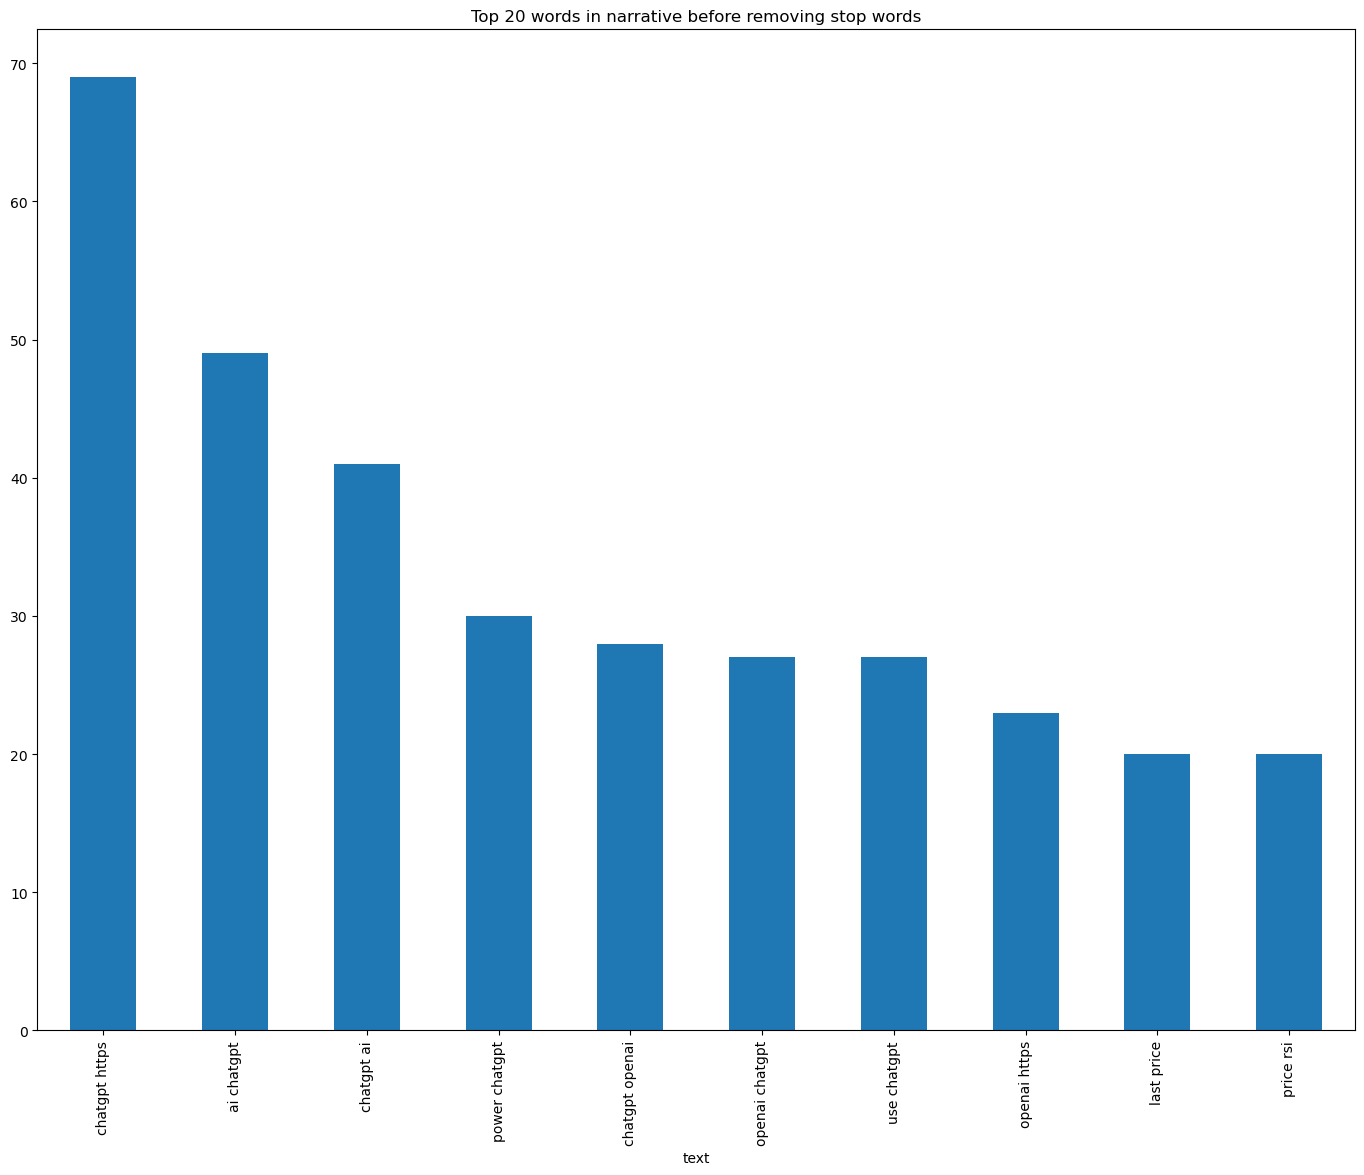

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text'], 10)
#for word, freq in common_words:
    #print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 20 words in narrative before removing stop words')

<Axes: title={'center': 'Top 20 words in narrative before removing stop words'}, xlabel='text'>

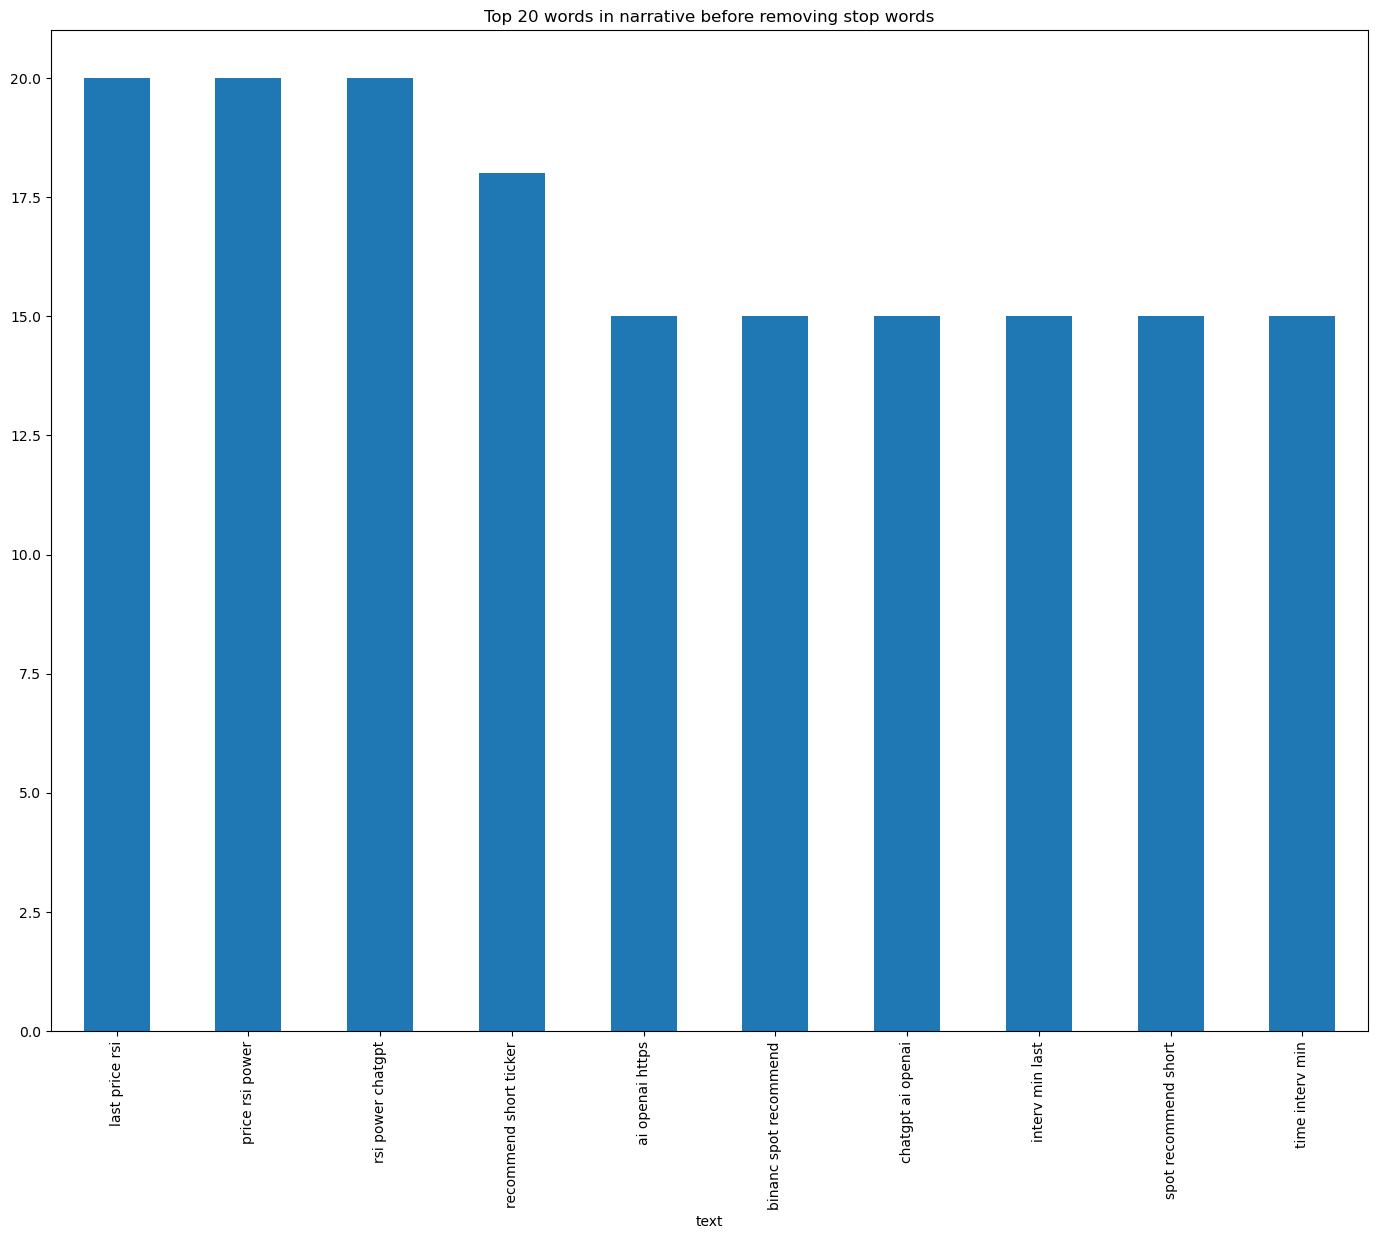

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['text'], 10)
#for word, freq in common_words:
    #print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top 20 words in narrative before removing stop words')

In [13]:
words=df['text'].values
ls=[]
for i in words:
    ls.append(str(i))

(-0.5, 1599.5, 799.5, -0.5)

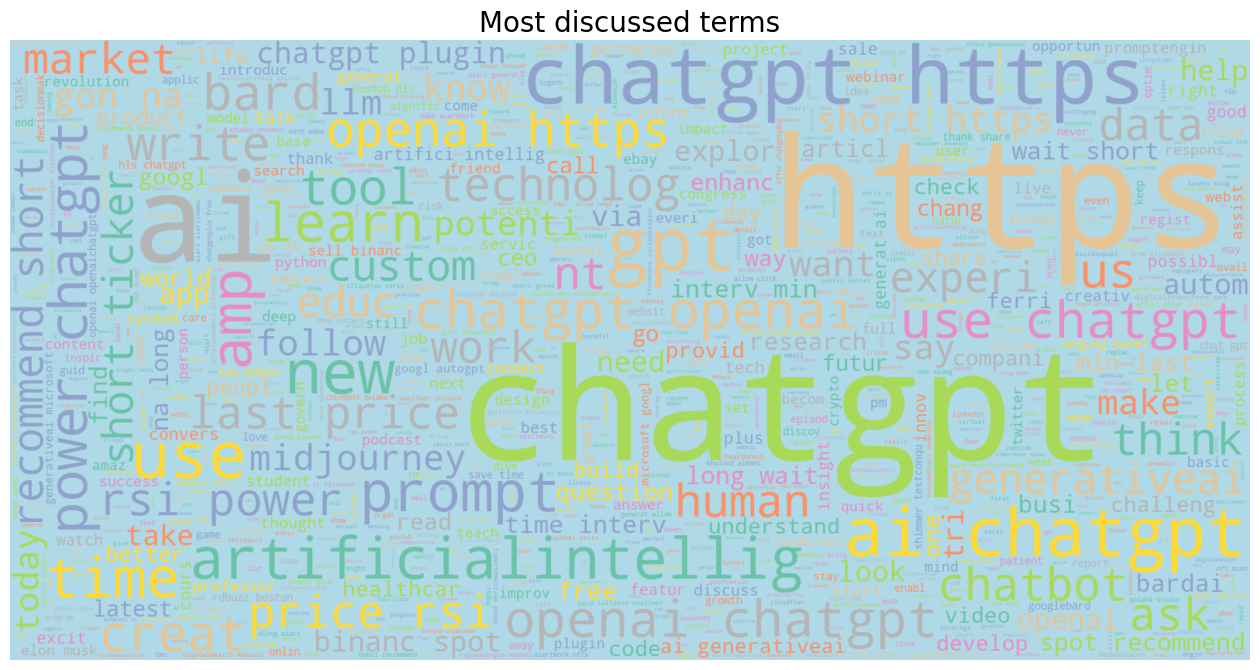

In [14]:
plt.figure(figsize=(16,13))
wc=WordCloud(background_color='lightblue',colormap='Set2',max_words=1000,max_font_size=200,width=1600,height=800)
wc.generate(" ".join(ls))
plt.title('Most discussed terms',fontsize=20)
plt.imshow(wc.recolor(colormap='Set2',random_state=17),alpha=0.98,interpolation='bilinear')
plt.axis('off')

## Segment Analysis

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
analyser=SentimentIntensityAnalyzer()
scores=[]
for i in range(len(df['text'])):
    score=analyser.polarity_scores(df['text'][i])
    score=score['compound']
    scores.append(score)
sentiment=[]
for i in scores:
    if i>=0.05:
        sentiment.append('Positive')
    elif i<=(-0.05):
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df['sentiment']=pd.Series(np.array(sentiment))

In [16]:
df.head(3)

user_name                                               text  \
0        Bohmle  gpt free clickbait qolaba studio chatbot power...   
1           NaN                                      ai enthusiast   
2  Dan Bruno AI  chatgpt think crypto coin explod year yahoo fi...   

               user_location  \
0                  Carkingga   
1  2019-07-03 03:44:41+00:00   
2             Manchester, NH   

                                    user_description  \
0                                                NaN   
1                                               60.0   
2  The latest in #ChatGPT, #BARD, #Bing, and othe...   

                user_created user_followers user_friends  \
0                        NaN            NaN          NaN   
1                      349.0            611        False   
2  2021-05-19 01:19:32+00:00          470.0        157.0   

             user_favourites         user_verified                       date  \
0                        NaN                   NaN                        NaN   
1  2023-05-17 18:11:12+00:00  ['GPT4', 'ChatGPT4']            Twitter Web App   
2                       5185                 False  2023-05-17 18:11:03+00:00   

                      hashtags   source sentiment  
0                           []      NaN  Positive  
1                           []      NaN  Positive  
2  ['chatgpt', 'AI', 'openAI']  dlvr.it   Neutral

In [17]:
# Sentiment count
temp=df.groupby('sentiment')['text'].count().reset_index().sort_values(by='sentiment',ascending=False)
temp.style.background_gradient(cmap='Blues')

In [18]:
from textblob import TextBlob
def vader_sentiment(sentence):
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(sentence)['compound']

def textblob_sentiment(sentence):
    return TextBlob(sentence).sentiment.polarity

def ensemble_sentiment(sentence):
    vader_score = vader_sentiment(sentence)
    textblob_score = textblob_sentiment(sentence)
    return (vader_score + textblob_score) / 2.0

df = df[df['text'].apply(lambda x: type(x) != float)]

df['ensemble_score'] = df['text'].apply(lambda sentences: [ensemble_sentiment(sentence) for sentence in sentences])
df['ensemble_mean_score'] = df['ensemble_score'].apply(lambda scores: sum(scores) / len(scores))
df.drop(['ensemble_score'], axis =1)

df.head()

user_name                                               text  \
0           Bohmle  gpt free clickbait qolaba studio chatbot power...   
1              NaN                                      ai enthusiast   
2     Dan Bruno AI  chatgpt think crypto coin explod year yahoo fi...   
3  Georgiana Comsa  new jwvanc post startup includ vcinityinc st s...   
4     Bitone Great  get binanc spot recommend short ticker ghstusd...   

               user_location  \
0                  Carkingga   
1  2019-07-03 03:44:41+00:00   
2             Manchester, NH   
3                  Palo Alto   
4                  Hong Kong   

                                    user_description  \
0                                                NaN   
1                                               60.0   
2  The latest in #ChatGPT, #BARD, #Bing, and othe...   
3  Founder of Silicon Valley PR, award-winning PR...   
4  #ChatGPT (AI) powered Free Trading Signal! \nL...   

                user_created user_followers user_friends  \
0                        NaN            NaN          NaN   
1                      349.0            611        False   
2  2021-05-19 01:19:32+00:00          470.0        157.0   
3  2008-12-24 09:32:23+00:00         3864.0       1883.0   
4  2022-11-21 04:42:18+00:00         1517.0        506.0   

             user_favourites         user_verified                       date  \
0                        NaN                   NaN                        NaN   
1  2023-05-17 18:11:12+00:00  ['GPT4', 'ChatGPT4']            Twitter Web App   
2                       5185                 False  2023-05-17 18:11:03+00:00   
3                       2415                 False  2023-05-17 18:10:25+00:00   
4                         64                 False  2023-05-17 18:09:39+00:00   

                           hashtags           source sentiment  \
0                                []              NaN  Positive   
1                                []              NaN  Positive   
2       ['chatgpt', 'AI', 'openAI']          dlvr.it   Neutral   
3         ['startups', 'startup50']  Twitter Web App  Positive   
4  ['Binance', 'Short', 'GHSTUSDT']             rsi1  Positive   

                                      ensemble_score  ensemble_mean_score  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             0.009391  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             0.000000  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             0.002637  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             0.003680  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...             0.004275

## Feature Engineering

In [19]:
df["word_count"]=df["text"].apply(lambda x : len(str(x).split()))
df[["text","word_count"]].head()

text  word_count
0  gpt free clickbait qolaba studio chatbot power...          25
1                                      ai enthusiast           2
2  chatgpt think crypto coin explod year yahoo fi...          13
3  new jwvanc post startup includ vcinityinc st s...          28
4  get binanc spot recommend short ticker ghstusd...          25

In [20]:
df["char_count"]=df["text"].apply(lambda x : len(str(x)))
df[["text","char_count"]].head()

text  char_count
0  gpt free clickbait qolaba studio chatbot power...         171
1                                      ai enthusiast          13
2  chatgpt think crypto coin explod year yahoo fi...          87
3  new jwvanc post startup includ vcinityinc st s...         187
4  get binanc spot recommend short ticker ghstusd...         161

In [22]:
def dialog_parser(text):
    
    tokenized = nltk.word_tokenize(text)
    
    # let's set up some lists to hold our pieces of narrative and dialog
    parsed_dialog = []
    parsed_narrative = []
    
    # and this list will be a bucket for the text we're currently exploring
    current = []
# now let's set up values that will help us loop through the text
    length = len(tokenized)
    found_q = False
    counter = 0
    quote_open, quote_close = '``', "''"
# now we'll start our loop saying that as long as our sentence is...
    while counter < length:
        word = tokenized[counter]
# until we find a quotation mark, we're working with narrative
        if quote_open not in word and quote_close not in word:
            current.append(word)
# here's what we do when we find a closed quote
        else:
            # we append the narrative we've collected & clear our our
            # current variable
            parsed_narrative.append(current)
            current = []
            
            # now current is ready to hold dialog and we're working on
            # a piece of dialog
            current.append(word)
            found_q = True
# while we're in the quote, we're going to increment the counter
            # and append to current in this while loop
            while found_q and counter < length-1:
                counter += 1
                if quote_close not in tokenized[counter]:
                    current.append(tokenized[counter])
                else:
                    # if we find a closing quote, we add our dialog to the
                    # appropriate list, clear current and flip our found_q
                    # variable to False
                    current.append(tokenized[counter])
                    parsed_dialog.append(current)
                    current = []
                    found_q = False
# increment the counter to move us through the text
        counter += 1
    
    if len(parsed_narrative) == 0:
        parsed_narrative.append(current)
    
    mean_dialog_word_len = 0
    
    if len(parsed_dialog) > 0:
        for text in parsed_dialog:
            join_text = " ".join(text)
            join_text = join_text.replace('"','')
            join_text = join_text.replace("''","")
            mean_dialog_word_len += len(join_text.split())
        
        mean_dialog_word_len /= float(len(parsed_dialog))
    
    mean_narrative_word_len = 0
    
    if len(parsed_narrative) > 0:
        for text in parsed_narrative:
            join_text = " ".join(text)
            join_text = join_text.replace('"','')
            join_text = join_text.replace("''","")
            mean_narrative_word_len += len(join_text.split())
        
        mean_narrative_word_len /= float(len(parsed_narrative))
    return len(parsed_dialog), len(parsed_narrative), mean_dialog_word_len, mean_narrative_word_len
def pos_count(sent):
    nn_count = 0   #Noun
    pr_count = 0   #Pronoun
    vb_count = 0   #Verb
    jj_count = 0   #Adjective
    uh_count = 0   #Interjection
    cd_count = 0   #Numerics
    
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    for token in sent:
        if token[1] in ['NN','NNP','NNS']:
            nn_count += 1
    if token[1] in ['PRP','PRP$']:
            pr_count += 1
    if token[1] in ['VB','VBD','VBG','VBN','VBP','VBZ']:
            vb_count += 1
    if token[1] in ['JJ','JJR','JJS']:
            jj_count += 1
    if token[1] in ['UH']:
            uh_count += 1
    if token[1] in ['CD']:
            cd_count += 1
    
    return pd.Series([nn_count, pr_count, vb_count, jj_count, uh_count, cd_count])

In [23]:
df[["nn_count","pr_count","vb_count","jj_count","uh_count","cd_count"]]=df["text"].apply(pos_count)
df[["text","nn_count","pr_count","vb_count","jj_count","uh_count","cd_count"]].head()

text  nn_count  pr_count  \
0  gpt free clickbait qolaba studio chatbot power...        16         0   
1                                      ai enthusiast         2         0   
2  chatgpt think crypto coin explod year yahoo fi...         9         0   
3  new jwvanc post startup includ vcinityinc st s...        24         0   
4  get binanc spot recommend short ticker ghstusd...        16         0   

   vb_count  jj_count  uh_count  cd_count  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         1         0         0  
4         0         0         0         0

## Count Vectorizer

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier


def perform_count_vectorization(documents):
    # Create an instance of CountVectorizer
    vectorizer = CountVectorizer()

    # Fit and transform the documents into a document-term matrix
    Tweet_vectors = vectorizer.fit_transform(documents)
    '''

    # Get the feature names (words) from the vectorizer
    feature_names = vectorizer.get_feature_names()

    # Create a DataFrame from the document-term matrix
    CountVec = pd.DataFrame(Tweet_vectors.toarray(), columns=feature_names)
    
    return Tweet_vectors
    '''



# Example usage:

Tweet_CV = perform_count_vectorization(df["text"])


## TFIDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

def perform_tfidf_vectorization(documents):
    # Create an instance of TfidfVectorizer
    vectorizer = TfidfVectorizer()

    # Fit and transform the documents into a TF-IDF matrix
    Tweet_Vectors = vectorizer.fit_transform(documents)

    # Get the feature names (words) from the vectorizer
    ''' feature_names = vectorizer.get_feature_names()

    # Create a DataFrame from the TF-IDF matrix
    df = pd.DataFrame(Tweet_Vectors.toarray(), columns=feature_names)'''

    return Tweet_Vectors

# Example usage:


Tweet_TFIDF = perform_tfidf_vectorization(df["text"])
print(Tweet_TFIDF)

  (0, 1776)	0.22626430991302351
  (0, 1775)	0.11501962578358399
  (0, 1716)	0.2321456454346973
  (0, 64)	0.2122381456978153
  (0, 1528)	0.17268867583374733
  (0, 1637)	0.23893514901987692
  (0, 1713)	0.20488031692916847
  (0, 472)	0.20840576521993145
  (0, 99)	0.2321456454346973
  (0, 1078)	0.1680481150551844
  (0, 60)	0.20488031692916847
  (0, 104)	0.22626430991302351
  (0, 3102)	0.13072922767005934
  (0, 436)	0.22626430991302351
  (0, 1759)	0.20840576521993145
  (0, 425)	0.08861824696100101
  (0, 1907)	0.1532283331417143
  (0, 424)	0.17787638141998596
  (0, 2355)	0.23893514901987692
  (0, 1978)	0.2321456454346973
  (0, 473)	0.2321456454346973
  (0, 1027)	0.35950180442712665
  (0, 1125)	0.14215929203380184
  (1, 851)	0.9609707317847695
  (1, 57)	0.2766500544967312
  :	:
  (499, 1708)	0.18393256880711942
  (499, 1184)	0.18393256880711942
  (499, 1543)	0.18393256880711942
  (499, 278)	0.18393256880711942
  (499, 1542)	0.18393256880711942
  (499, 3188)	0.18393256880711942
  (499, 53)	0.1

In [26]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def perform_doc2vec_embedding(documents):
    # Prepare the tagged documents
    tagged_documents = [TaggedDocument(words=d.split(), tags=[str(i)]) for i, d in enumerate(documents)]

    # Create an instance of Doc2Vec model
    model = Doc2Vec(vector_size=100, min_count=2, epochs=40)

    # Build the vocabulary
    model.build_vocab(tagged_documents)

    # Train the Doc2Vec model
    model.train(tagged_documents, total_examples=model.corpus_count, epochs=model.epochs)

    # Get the document vectors
    vectors = [model.docvecs[str(i)] for i in range(len(documents))]

    return vectors




TWeets_D2V = perform_doc2vec_embedding(df["text"])
print(TWeets_D2V)

[array([-0.05152529,  0.11121336,  0.06780073,  0.03317332,  0.11387379,
       -0.21765971,  0.02867195,  0.27291897, -0.18353015, -0.13377507,
       -0.09916253, -0.07255257, -0.00420024,  0.04622177,  0.00675253,
       -0.18550794,  0.13366553, -0.11335928, -0.04977265, -0.17536275,
        0.06977326, -0.03894697,  0.07982281, -0.04418628,  0.00527799,
       -0.05832003, -0.15181313, -0.10144835, -0.15480341, -0.00334387,
        0.14646676,  0.03869266, -0.01776541, -0.06255179,  0.01979589,
        0.1368504 ,  0.01361459, -0.08593777, -0.00782752, -0.12546283,
        0.04985384, -0.10824711,  0.01329894, -0.04040908, -0.02079724,
       -0.14102802, -0.04555489,  0.01544102,  0.0387536 ,  0.10831886,
        0.08939883, -0.07772142, -0.04566092, -0.02178608, -0.09585263,
        0.18853033,  0.02679337,  0.02159894, -0.12843153,  0.02139831,
       -0.00904806,  0.04422641,  0.00533451, -0.07762737, -0.2235725 ,
        0.15082455,  0.17815062,  0.02061993, -0.17683303,  0.0

In [27]:
from sklearn.model_selection import train_test_split

#only working with text blob and tfidf atm

print("[TextBlob, TFIDF]\n\n")
#[TextBlob, TFIDF]
train_vectors_TFIDF, test_vecors_TFIDF, train_labels_tb, test_labels_tb = train_test_split(Tweet_TFIDF, df["sentiment"], test_size=0.3, random_state=42)

# Print the shapes of the resulting subsets
print("Training data shape:", train_vectors_TFIDF.shape, train_labels_tb.shape)
print("Testing data shape:", test_vecors_TFIDF.shape, test_labels_tb.shape)






[TextBlob, TFIDF]


Training data shape: (350, 3277) (350,)
Testing data shape: (150, 3277) (150,)


In [28]:
df.head()

user_name                                               text  \
0           Bohmle  gpt free clickbait qolaba studio chatbot power...   
1              NaN                                      ai enthusiast   
2     Dan Bruno AI  chatgpt think crypto coin explod year yahoo fi...   
3  Georgiana Comsa  new jwvanc post startup includ vcinityinc st s...   
4     Bitone Great  get binanc spot recommend short ticker ghstusd...   

               user_location  \
0                  Carkingga   
1  2019-07-03 03:44:41+00:00   
2             Manchester, NH   
3                  Palo Alto   
4                  Hong Kong   

                                    user_description  \
0                                                NaN   
1                                               60.0   
2  The latest in #ChatGPT, #BARD, #Bing, and othe...   
3  Founder of Silicon Valley PR, award-winning PR...   
4  #ChatGPT (AI) powered Free Trading Signal! \nL...   

                user_created user_followers user_friends  \
0                        NaN            NaN          NaN   
1                      349.0            611        False   
2  2021-05-19 01:19:32+00:00          470.0        157.0   
3  2008-12-24 09:32:23+00:00         3864.0       1883.0   
4  2022-11-21 04:42:18+00:00         1517.0        506.0   

             user_favourites         user_verified                       date  \
0                        NaN                   NaN                        NaN   
1  2023-05-17 18:11:12+00:00  ['GPT4', 'ChatGPT4']            Twitter Web App   
2                       5185                 False  2023-05-17 18:11:03+00:00   
3                       2415                 False  2023-05-17 18:10:25+00:00   
4                         64                 False  2023-05-17 18:09:39+00:00   

   ...                                     ensemble_score ensemble_mean_score  \
0  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            0.009391   
1  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            0.000000   
2  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            0.002637   
3  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            0.003680   
4  ...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...            0.004275   

  word_count char_count  nn_count  pr_count  vb_count  jj_count  uh_count  \
0         25        171        16         0         0         0         0   
1          2         13         2         0         0         0         0   
2         13         87         9         0         0         0         0   
3         28        187        24         0         0         1         0   
4         25        161        16         0         0         0         0   

   cd_count  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 23 columns]